In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Evaluation metrics
# actual and forecast are two Series objects
def calc_rmse(actual, forecast):
    return np.sqrt(mean_squared_error(actual, forecast))

def calc_mape(actual, forecast):
    return np.mean(np.abs((actual-forecast)/actual))*100

dfModels = pd.DataFrame(columns=['Model','RMSE','MAPE'])

In [3]:
df = pd.read_csv('data.csv')
df.head()

,Unnamed: 0,reported_date,COST,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,1,1/1/21 0:00,1835.2176,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2/1/21 0:00,2034.4105,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,3/1/21 0:00,1417.2036,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,4/1/21 0:00,1236.9953,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,5/1/21 0:00,1428.5095,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df = df[['reported_date','COST']]
df.columns = ['date','cost']
df['date'] = pd.to_datetime(df['date'])
df.set_index('date',inplace=True)
df.head()

,cost
date,
2021-01-01,1835.2176
2021-02-01,2034.4105
2021-03-01,1417.2036
2021-04-01,1236.9953
2021-05-01,1428.5095


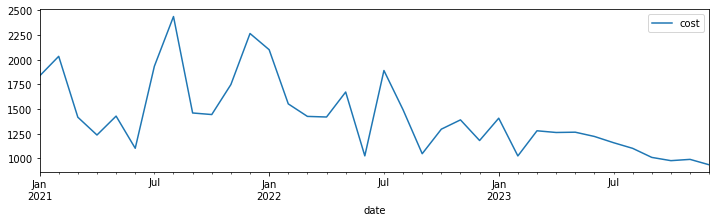

In [6]:
# Plotting the dataset
plt.rcParams['figure.figsize'] = (12,3)
df.plot()
plt.show()
# df_2021 = df[df['date'] < datetime(2022,1,1)]
# df_2022 = df[(df['date'] < datetime(2023,1,1)) & (df['date'] >= datetime(2022,1,1))]
# df_2023 = df[df['date'] >= datetime(2023,1,1)]

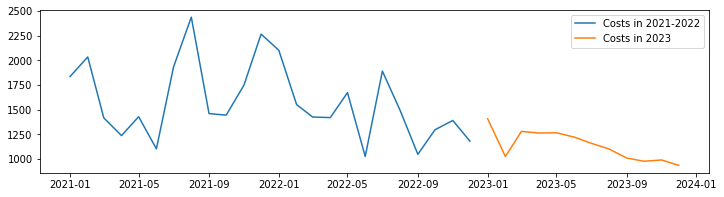

In [8]:
# Splitting the dataset into train and test datasets
dfTrain = df['2021-01-01':'2022-12-01']
dfTest = df['2023-01-01':'2023-12-01']

# Visualizing the train and test datasets
plt.rcParams['figure.figsize'] = (12,3)
plt.plot(dfTrain['cost'], label = 'Costs in 2021-2022')
plt.plot(dfTest['cost'], label = 'Costs in 2023')
plt.legend(loc='best')
plt.show()

Additive decomposition


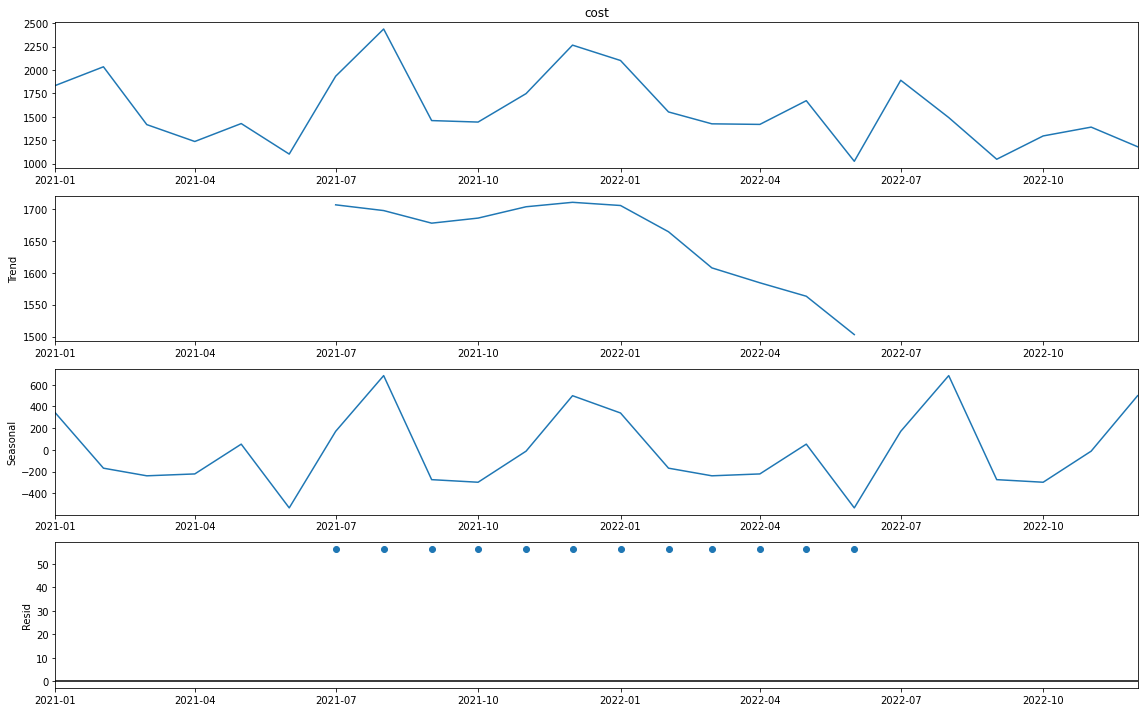

Multiplicative decomposition


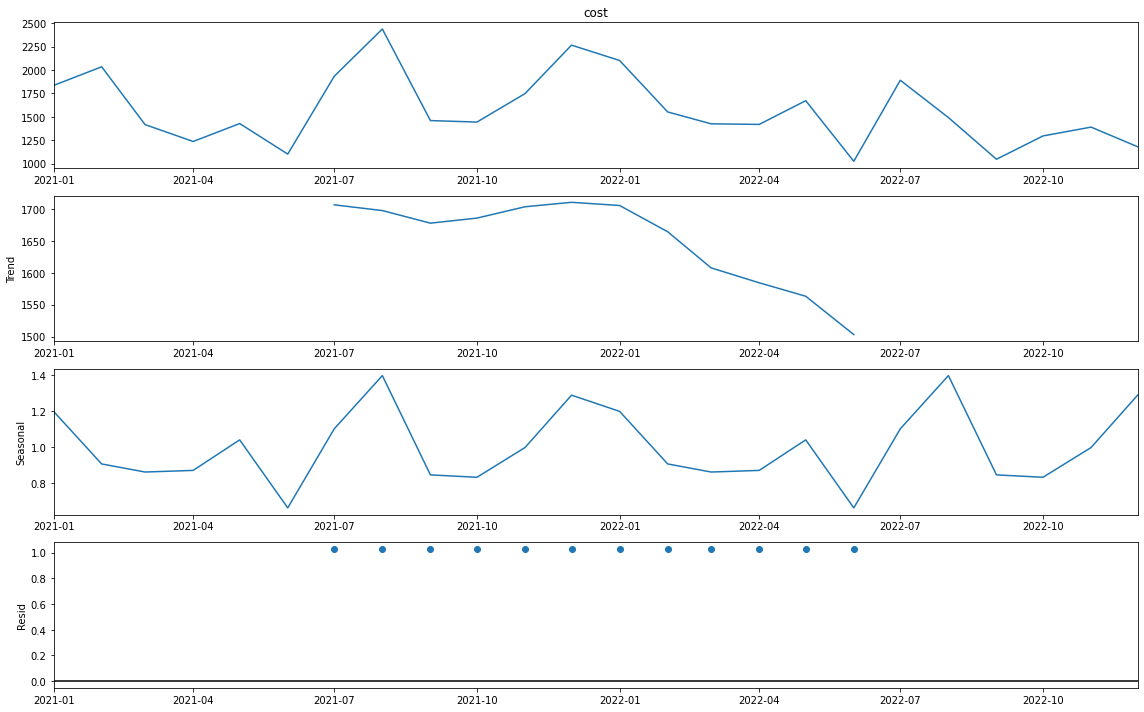

In [9]:
# Separating the trend, seasonality and irregularities from the time series
add_decomp = sm.tsa.seasonal_decompose(dfTrain.cost, model='additive',period=12)
mul_decomp = sm.tsa.seasonal_decompose(dfTrain.cost, model='multiplicative',period=12)
plt.rcParams['figure.figsize'] = (16,10)
print('Additive decomposition')
fig2 = add_decomp.plot()
plt.show()
print('Multiplicative decomposition')
fig2 = mul_decomp.plot()
plt.show()

# Naive and Simple methods

In the Naive methods, we assume that the future value will either be the same as the previous value or the average of all the previous values. They are generally not good forecasting methods as they assume the future will have a constant value throughout. They capture neither the trend, nor the seasonality in the dataset.

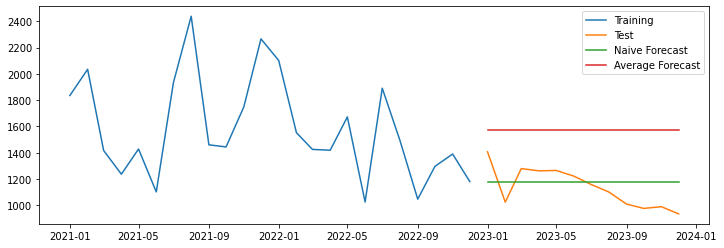

In [10]:
# The first method is a Naive method where y(t) = y(t-1)
# The second method is another simple method where y(t) = avg(y)
# Both these methods give a value that remains unchanged, thus they are not good forecast methods 
# as they do not capture either trend or seasonality.

# DF can be thought of as a 2D array
dfTest['naive_forecast'] = dfTrain['cost'][-1]                  # The last value in the training dataset
dfTest['average_forecast'] = np.mean(dfTrain['cost'])           # The average value computed with the training dataset


plt.rcParams['figure.figsize'] = (12,4)
plt.plot(dfTrain['cost'], label='Training')
plt.plot(dfTest['cost'], label='Test')
plt.plot(dfTest['naive_forecast'], label='Naive Forecast')
plt.plot(dfTest['average_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

In [11]:
# Figuring out the metrics
rmseNaive = calc_rmse(dfTest['cost'], dfTest['naive_forecast'])
mapeNaive = calc_mape(dfTest['cost'], dfTest['naive_forecast'])

rmseAvg = calc_rmse(dfTest['cost'], dfTest['average_forecast'])
mapeAvg = calc_mape(dfTest['cost'], dfTest['average_forecast'])

dfModels.loc[len(dfModels)] = ['Naive Forecast', rmseNaive, mapeNaive]
dfModels.loc[len(dfModels)] = ['Average Forecast', rmseAvg, mapeAvg]
dfModels

,Model,RMSE,MAPE
0,Naive Forecast,151.545380,12.339956
1,Average Forecast,463.587239,41.003261


In [12]:
# The Simple Moving Average method
# Need to do self-implementation

length = len(dfTrain)
window = len(dfTrain)                     # The size of the window, can be changed
dfSMA = dfTrain.copy()
a = len(dfTrain) - window
for i in range(len(dfTest)):                # We run the loop only to forecast the testing dataset
    sma = np.mean(dfSMA['cost'][a:window])
    a+=1
    dfSMA.loc[len(dfSMA)] = [sma]
# display(dfSMA)
# display(dfSMA.loc[length:,'cost']) 
dfTest['sma_forecast'] = list(dfSMA.loc[length:,'cost'])     # Adding the sma forecast values to the test dataset for comparison
dfTest

,cost,naive_forecast,average_forecast,sma_forecast
date,,,,
2023-01-01,1407.337100,1181.1421,1576.671004,1576.671004
2023-02-01,1024.781900,1181.1421,1576.671004,1565.429848
2023-03-01,1279.751736,1181.1421,1576.671004,1544.112545
2023-04-01,1262.528314,1181.1421,1576.671004,1550.155829
2023-05-01,1265.487543,1181.1421,1576.671004,1565.813855
2023-06-01,1222.286341,1181.1421,1576.671004,1573.040400
2023-07-01,1159.085976,1181.1421,1576.671004,1599.181100
2023-08-01,1101.791435,1181.1421,1576.671004,1579.503482
2023-09-01,1009.992655,1181.1421,1576.671004,1525.863513


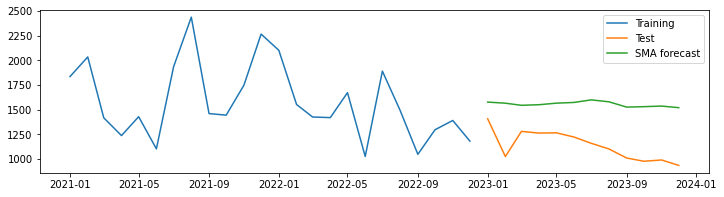

,Model,RMSE,MAPE
0,Naive Forecast,151.545380,12.339956
1,Average Forecast,463.587239,41.003261
2,SMA Forecast,439.853052,38.953079


In [13]:
# Plotting the graph and computing the metrics
plt.rcParams['figure.figsize'] = (12,3)
plt.plot(dfTrain['cost'], label='Training')
plt.plot(dfTest['cost'], label='Test')
plt.plot(dfTest['sma_forecast'], label='SMA forecast')
plt.legend(loc='best')
plt.show()

rmseSMA = calc_rmse(dfTest['cost'], dfTest['sma_forecast'])
mapeSMA = calc_mape(dfTest['cost'], dfTest['sma_forecast'])
dfModels.loc[len(dfModels)] = ['SMA Forecast', rmseSMA, mapeSMA]
dfModels

# Exponential Smoothing Methods

Exponential smoothing methods assume decaying importance of data as we go further in the past. Holt-Winters method is used (triple-exponential smoothing) to ensure that level, seasonality and trend are captured.

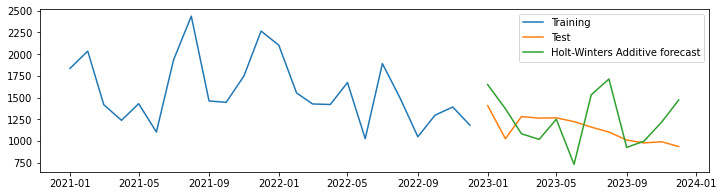

,Model,RMSE,MAPE
0,Naive Forecast,151.545380,12.339956
1,Average Forecast,463.587239,41.003261
2,SMA Forecast,439.853052,38.953079
3,Holt-Winters Additive,338.975264,25.446876


In [14]:
# Performing Holt-Winter's Additive and Multiplicative models and comparing their results
# Alpha, Beta and Gamma can be given if needed

add_model = ExponentialSmoothing(dfTrain['cost'], trend='add', seasonal='add', seasonal_periods=12).fit(optimized=True)
# Asking the function to figure out the best smoothing parameters by maximizing log-likelihood

dfTest['HW_Additive'] = add_model.forecast(len(dfTest))

# Plotting the forecasts
plt.rcParams['figure.figsize'] = (12,3)
plt.plot(dfTrain['cost'], label='Training')
plt.plot(dfTest['cost'], label='Test')
plt.plot(dfTest['HW_Additive'], label='Holt-Winters Additive forecast')
plt.legend(loc='best')
plt.show()

# Adding the metrics to dfModels
rmseHW_Add = calc_rmse(dfTest['cost'], dfTest['HW_Additive'])
mapeHW_Add = calc_mape(dfTest['cost'], dfTest['HW_Additive'])
dfModels.loc[len(dfModels)] = ['Holt-Winters Additive', rmseHW_Add, mapeHW_Add]
dfModels

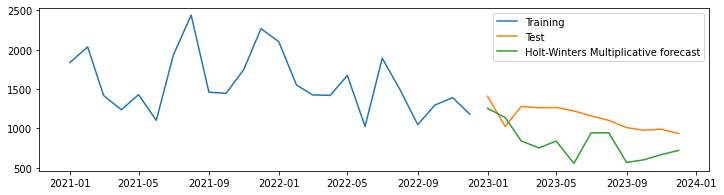

,Model,RMSE,MAPE
0,Naive Forecast,151.545380,12.339956
1,Average Forecast,463.587239,41.003261
2,SMA Forecast,439.853052,38.953079
3,Holt-Winters Additive,338.975264,25.446876
4,Holt-Winters Mul,373.207425,29.597310


In [15]:
# Holt-Winters Multiplicative
mul_model = ExponentialSmoothing(dfTrain['cost'], trend='mul', seasonal='mul', seasonal_periods=12).fit(optimized=True)
# Asking the function to figure out the best smoothing parameters by maximizing log-likelihood

dfTest['HW_Mul'] = mul_model.forecast(len(dfTest))

# Plotting the forecasts
plt.rcParams['figure.figsize'] = (12,3)
plt.plot(dfTrain['cost'], label='Training')
plt.plot(dfTest['cost'], label='Test')
plt.plot(dfTest['HW_Mul'], label='Holt-Winters Multiplicative forecast')
plt.legend(loc='best')
plt.show()

# Adding the metrics to dfModels
rmseHW_Mul = calc_rmse(dfTest['cost'], dfTest['HW_Mul'])
mapeHW_Mul = calc_mape(dfTest['cost'], dfTest['HW_Mul'])
dfModels.loc[len(dfModels)] = ['Holt-Winters Mul', rmseHW_Mul, mapeHW_Mul]
dfModels

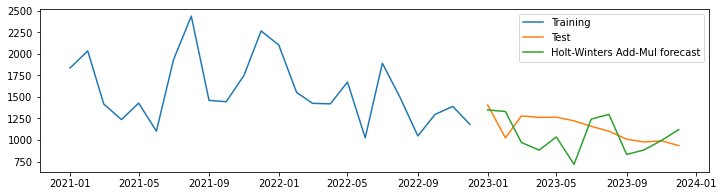

,Model,RMSE,MAPE
0,Naive Forecast,151.545380,12.339956
1,Average Forecast,463.587239,41.003261
2,SMA Forecast,439.853052,38.953079
3,Holt-Winters Additive,338.975264,25.446876
4,Holt-Winters Mul,373.207425,29.597310
5,Holt-Winters Modified,252.441962,18.352631


In [16]:
# Trend is additive and Seasonality is multiplicative -> my best guess
new_model = ExponentialSmoothing(dfTrain['cost'], trend='add', seasonal='mul', seasonal_periods=12).fit(optimized=True)
# Asking the function to figure out the best smoothing parameters by maximizing log-likelihood

dfTest['HW_New'] = new_model.forecast(len(dfTest))

# Plotting the forecasts
plt.rcParams['figure.figsize'] = (12,3)
plt.plot(dfTrain['cost'], label='Training')
plt.plot(dfTest['cost'], label='Test')
plt.plot(dfTest['HW_New'], label='Holt-Winters Add-Mul forecast')
plt.legend(loc='best')
plt.show()

# Adding the metrics to dfModels
rmseHW_New = calc_rmse(dfTest['cost'], dfTest['HW_New'])
mapeHW_New = calc_mape(dfTest['cost'], dfTest['HW_New'])
dfModels.loc[len(dfModels)] = ['Holt-Winters Modified', rmseHW_New, mapeHW_New]
dfModels

Holt-Winters performs well if the seasonailty is assumed to be multiplicative and the trend is assumed to be additive. This depends on the dataset. For this particular dataset, an add-mul Holt-Winters model seems to be the best-suited.

# Auto-Regressive Methods

Before we can perform any autoregressive analysis, we have to make sure that the time-series dataset is stationary (has constant mean and variance). We perform an Augmented Dickey-Fuller test to check for stationarity. The null and alternate hypotheses of this test are:

        H0: The time-series is not stationary
        Ha: The time-series is stationary

In [17]:
# Checking for stationarity
adfTest = adfuller(df['cost'])
print('p-value is', adfTest[1])         # If p-value is greater than 0.05, time series is not stationary

p-value is 0.9077612095527412


Since the p-value is more than 0.05, the time series dataset is not stationary (non-constant mean and variance). We apply Box-Cox transformation for making the variance of the time-series constant and we use the differencing to make the mean constant.

In [18]:
# Applying box-cox
bxcx = pd.Series(boxcox(df['cost'], lmbda=0),index=df.index)     # since lmbda=0, its just a log transformation

# Differencing
bxcxDiff = pd.Series(bxcx - bxcx.shift(1),index=df.index)        # The period of differencing is one month

# Removing NaN values (only the first value will be removed)
bxcxDiff.dropna(inplace=True)

# Performing ADF test again to check stationarity
adfTest = adfuller(bxcxDiff)
print('p-value is: ',adfTest[1])

p-value is:  0.0011217015176939137


Since the p-value is lesser than 0.05, the time-series has been converted to a stationary one. We can now apply the ARIMA and the SARIMA models

## Quick Sanity Check
It would be prudent to see, at this point, if we can retrieve the original time-series data from the transformation.

In [19]:
#display(df)
#display(bxcxDiff)
try1 = pd.DataFrame()
try1['bxcx'] = bxcxDiff.cumsum()
try1['bxcx'] = try1['bxcx'].add(bxcx[0])
try1['recovered'] = np.exp(try1['bxcx'])            
try1['original'] = df['cost']
try1

,bxcx,recovered,original
date,,,
2021-02-01,7.617961,2034.410500,2034.410500
2021-03-01,7.256441,1417.203600,1417.203600
2021-04-01,7.120441,1236.995300,1236.995300
2021-05-01,7.264387,1428.509500,1428.509500
2021-06-01,7.005343,1102.507800,1102.507800
2021-07-01,7.567191,1933.700600,1933.700600
2021-08-01,7.798828,2437.743000,2437.743000
2021-09-01,7.286336,1460.210800,1460.210800
2021-10-01,7.275404,1444.335300,1444.335300


The first month's value is obviously removed. Everything else is recovered correctly

In [20]:
# Splitting the newly transformed series into train and test dataset
split = len(dfTrain)-1              # This is essentially the length of the training dataset (-1 since we removed the NaN value)
train = bxcxDiff[:split]
test = bxcxDiff[split:]

In [21]:
# Testing out AR, ARMA and ARIMA models
model1 = ARIMA(train,order=(1,0,0)).fit()                                      # This is an Auto-Regressive (AR) model
model2 = ARIMA(train,order=(1,0,1)).fit()                                      # This is an ARMA model
model3 = ARIMA(train,order=(1,1,1)).fit()                                      # This is an ARIMA model
model4 = SARIMAX(train,order=(1,1,1),seasonal_order=(1,1,1,12)).fit()          # This is a SARIMA model with period as 1 year


# Predicting the values
forecast1 = model1.predict(start=test.index.min(),end=test.index.max())
forecast2 = model2.predict(start=test.index.min(),end=test.index.max())
forecast3 = model3.predict(start=test.index.min(),end=test.index.max())
forecast4 = model4.predict(start=test.index.min(),end=test.index.max())

lst = [forecast1,forecast2,forecast3,forecast4]
names = ['AR_model','ARMA_model','ARIMA_model','SARIMA_model']
x = 0
# Recovering proper values from the forecasts
for i in lst:
    dummy = pd.DataFrame()
    dummy['bxcx'] = i.cumsum()
    dummy['bxcx'] = dummy['bxcx'].add(bxcx[0])
    dummy['final'] = np.exp(dummy['bxcx'])
    dfTest[names[x]] = dummy['final']
    x+=1
dfTest

,cost,naive_forecast,average_forecast,sma_forecast,HW_Additive,HW_Mul,HW_New,AR_model,ARMA_model,ARIMA_model,SARIMA_model
date,,,,,,,,,,,
2023-01-01,1407.337100,1181.1421,1576.671004,1576.671004,1648.355600,1255.183189,1348.559092,1881.557898,2011.739367,1872.576989,1884.824593
2023-02-01,1024.781900,1181.1421,1576.671004,1565.429848,1370.844597,1136.934368,1330.828376,1821.771721,2025.047776,1818.020571,938.568179
2023-03-01,1279.751736,1181.1421,1576.671004,1544.112545,1082.576936,840.285679,971.268334,1794.874339,2007.923958,1789.024312,1122.401856
2023-04-01,1262.528314,1181.1421,1576.671004,1550.155829,1017.067695,752.909023,882.582133,1759.026046,1985.636793,1754.059343,1265.887073
2023-05-01,1265.487543,1181.1421,1576.671004,1565.813855,1249.823878,838.731719,1035.388881,1726.676669,1962.669503,1721.486180,1517.583159
2023-06-01,1222.286341,1181.1421,1576.671004,1573.040400,729.150643,556.255714,717.063580,1694.090391,1939.805672,1689.062834,744.215458
2023-07-01,1159.085976,1181.1421,1576.671004,1599.181100,1530.423560,942.877215,1242.912038,1662.367419,1917.179822,1657.371294,1436.216129
2023-08-01,1101.791435,1181.1421,1576.671004,1579.503482,1713.557498,944.872853,1297.152996,1631.164317,1894.812917,1626.242128,720.949835
2023-09-01,1009.992655,1181.1421,1576.671004,1525.863513,925.143506,568.237849,832.504070,1600.569053,1872.706089,1595.706222,587.939493


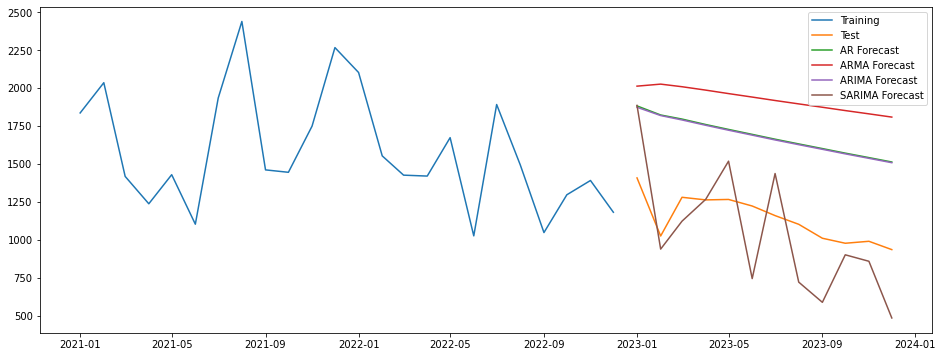

In [22]:
# Plotting all graphs
plt.rcParams['figure.figsize'] = (16,6)
plt.plot(dfTrain['cost'], label='Training')
plt.plot(dfTest['cost'], label='Test')
plt.plot(dfTest['AR_model'], label='AR Forecast')
plt.plot(dfTest['ARMA_model'], label='ARMA Forecast')
plt.plot(dfTest['ARIMA_model'], label='ARIMA Forecast')
plt.plot(dfTest['SARIMA_model'], label='SARIMA Forecast')
plt.legend(loc='best')
plt.show()

In [23]:
# Computing the evaluation metrics for all the models
names = ['AR_model','ARMA_model','ARIMA_model','SARIMA_model']
x = 0
for i in range(len(names)):
    rmse = calc_rmse(dfTest['cost'], dfTest[names[i]])
    mape = calc_mape(dfTest['cost'], dfTest[names[i]])
    dfModels.loc[len(dfModels)] = [names[i], rmse, mape]
dfModels

,Model,RMSE,MAPE
0,Naive Forecast,151.545380,12.339956
1,Average Forecast,463.587239,41.003261
2,SMA Forecast,439.853052,38.953079
3,Holt-Winters Additive,338.975264,25.446876
4,Holt-Winters Mul,373.207425,29.597310
5,Holt-Winters Modified,252.441962,18.352631
6,AR_model,553.665452,49.513303
7,ARMA_model,795.693974,71.573392
8,ARIMA_model,548.604355,49.054506
9,SARIMA_model,313.336600,23.620399


### Comparisons
If we go by metrics alone, then the Naive method seems to perform the best. However, it captures neither the trend, nor the seasonality. Thus, it is not a useful model at all.

The modified Holt-Winters model and the SARIMA model seem to perform the best, based on the Mean Absolute Percent Error (MAPE) and Root Mean Squared Error (RMSE) values. 

# Forecast for the next 12 months
Since we have settled on the modified Holt-Winters and the SARIMA models, we will forecast the predicted values for the next 12 months. We re-train both the models with the entire dataset for this purpose.

In [24]:
# Creating a new dataframe to store forecasted values
new = pd.DataFrame(index=pd.date_range(start='2024-01-01',end='2024-12-01',freq='MS'))

# Modified Holt-Winters Model
HW_model = ExponentialSmoothing(df['cost'], trend='add', seasonal='mul', seasonal_periods=12).fit(optimized=True)
new['HW_forecast'] = HW_model.forecast(len(new))

# SARIMA Model
sarimaModel = SARIMAX(bxcxDiff,order=(1,1,1),seasonal_order=(1,1,1,12)).fit()
sarimaForecast = sarimaModel.predict(start=new.index.min(),end=new.index.max())

# Decoding the SARIMA forecast into original values and adding it to the dataframe
dummy = pd.DataFrame()
dummy['bxcx'] = sarimaForecast.cumsum()
dummy['bxcx'] = dummy['bxcx'].add(bxcx[0])
new['SARIMA_forecast'] = np.exp(dummy['bxcx'])

new

,HW_forecast,SARIMA_forecast
2024-01-01,1021.362874,2043.814103
2024-02-01,945.974118,1500.664030
2024-03-01,747.661318,1801.999089
2024-04-01,699.634716,1755.736030
2024-05-01,774.543160,1747.557861
2024-06-01,579.452207,1633.237170
2024-07-01,849.876641,1577.777415
2024-08-01,836.182091,1474.933466
2024-09-01,563.395952,1313.095148
2024-10-01,578.851837,1264.623461


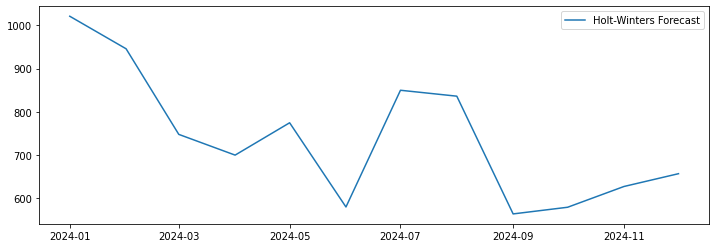

In [25]:
# Plotting the Holt-Winters model forecast
plt.rcParams['figure.figsize'] = (12,4)
plt.plot(new['HW_forecast'], label = 'Holt-Winters Forecast')
plt.legend(loc='best')
plt.show()

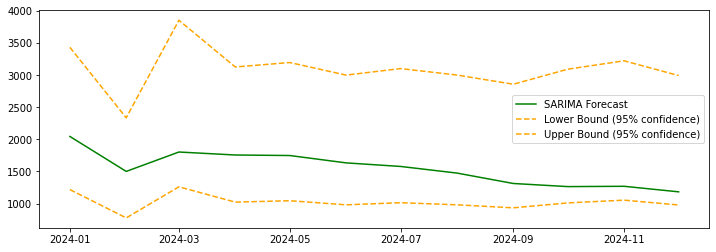

In [26]:
# Plotting the SARIMA model forecasts with confidence interval
result = sarimaModel.get_forecast(steps=12)
ci = result.conf_int(0.05)                            # 95% confidence interval

ci['bxcx_lower'] = ci['lower cost'].cumsum()
ci['bxcx_lower'] = ci['lower cost'].add(bxcx[0])
ci['lower_range'] = np.exp(ci['bxcx_lower'])

ci['bxcx_upper'] = ci['upper cost'].cumsum()
ci['bxcx_upper'] = ci['upper cost'].add(bxcx[0])
ci['upper_range'] = np.exp(ci['bxcx_upper'])

ci = ci[['lower_range','upper_range']]
#display(ci)

plt.rcParams['figure.figsize'] = (12,4)
plt.plot(new['SARIMA_forecast'], color='green', label = 'SARIMA Forecast')
plt.plot(ci['lower_range'], linestyle='dashed', color='orange', label = 'Lower Bound (95% confidence)')
plt.plot(ci['upper_range'], linestyle='dashed', color='orange', label = 'Upper Bound (95% confidence)')
plt.legend(loc='best')
plt.show()